<!-- **Name:** Noah S. Roberts <br /> -->
**NetID:** nr207489

---

<!-- [![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KNN.ipynb) -->

Names of students you worked with on this assignment: 

- Nathan "Buffis" Johnson
- Bella Wengapully

::: {.callout-note}
This assignment falls under collaboration Mode 1: Collaborative Assignment – Collaboration Required! Please refer to the [syllabus on Canvas](https://canvas.umt.edu/courses/21767/assignments/syllabus) under "Course Expectations & Policies" for additional information.
:::

Instructions for all assignments can be found [here](https://github.com/lucywowen/csci547_ML/blob/main/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the course syllabus.

This is a practice assignment to get you familiar with the assignment format, environment set up, and

## Learning Objectives

- Become familiar with the assignment format
- Work on environment set up (Colab is totally fine to start)
- Figure out how to output the notebook and submit it to canvas.
- Practice end-to-end ML processes using KNN
- K-Nearest Neighbours : Our goal is to implement a KNN classifier and apply it to classify the Iris dataset.

---

# KNN

## Data processing and visualization

We always have this set of imports at the beginning of our notebooks and set the random seed.

In [1]:
import numpy as np
# The output of plotting commands is displayed inline within frontends
%matplotlib inline
import matplotlib.pyplot as plt

# It is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(1234)

We also set some configurations for Jupyter and IPython for better type hinting and code suggestions

::: {.callout-note}
I added this, as I consider LSP-based type hinting and type-aware code suggestions (not inline completion) a must.
:::

In [2]:
%config IPCompleter.use_jedi = False
%config Completer.evaluation = 'limited'

We conveniently load the dataset from the sklearn collection of datasets. To start, we will use the Iris dataset.

In [3]:
from sklearn import datasets

# To read more about load_iris() function refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
dataset = datasets.load_iris()

We create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$.
Let's only use `sepal length` and `sepal width` for classification, since we know they have high correlation with the class label. We then randomly split the data into train and test and visualize the data.

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


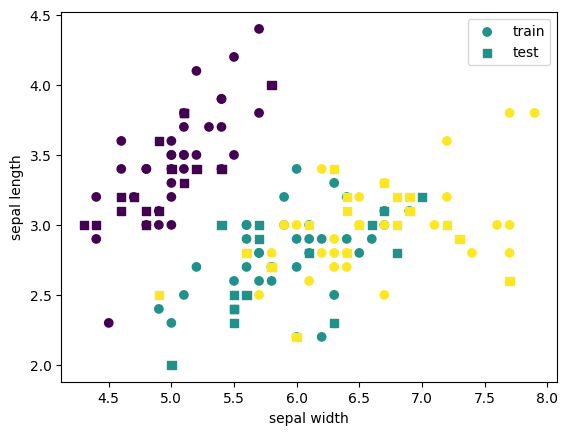

In [4]:
# Slices the first two columns or features from the data
x, y = dataset.data[:,:2], dataset.target

# Print the feature shape and classes of dataset
qty_instances, qty_features = x.shape
qty_class_labels = np.max(y) + 1
print(f'instances (N) \t {qty_instances} \n features (D) \t {qty_features} \n classes (C) \t {qty_class_labels}')

# Generates an indices array from 0 to N-1 and permutes it
indices = np.random.permutation(qty_instances)

# Split the dataset into train and test
x_train, y_train = x[indices[:100]], y[indices[:100]]  # second half
x_test,  y_test  = x[indices[100:]], y[indices[100:]]  # first half

# Visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
## set up the legend
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
## show the plot
plt.show()

**[Practice]**


Can you replicate this using the `train_test_split` in `sklearn`?

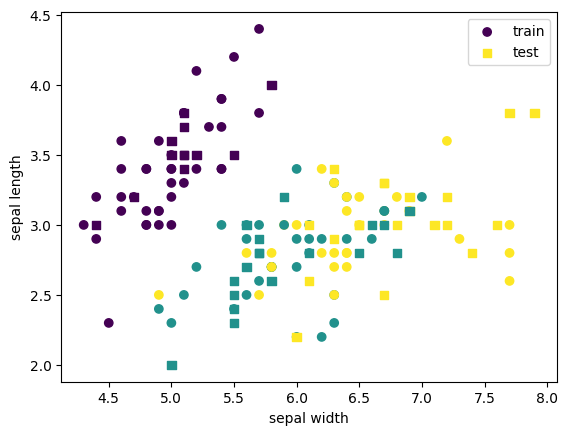

In [14]:
from sklearn.model_selection import train_test_split

### Fill in the code below to replicate the figure above using this function
### The exact train and test data points can be different!
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1/3), shuffle=True)

# Visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
## set up the legend
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
## show the plot
plt.show()

## The `KNN` class
We implement our models as python classes. Two class methods that we usually need to implement are `fit` and `predict`; which respectively perform training by fitting the data, and making prediction on new data. In the `__init__` function, we initialize our model, usually this includes an assignment to *hyper-parameters*.

First though... let's define some distance metrics.  I'll give you the Manhattan metric, but you figure out the Euclidean metric yourself!

**[Practice]**


Can you fill in the euclidean metric?

In [6]:
# Define the metric we will use to measure similarity
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))

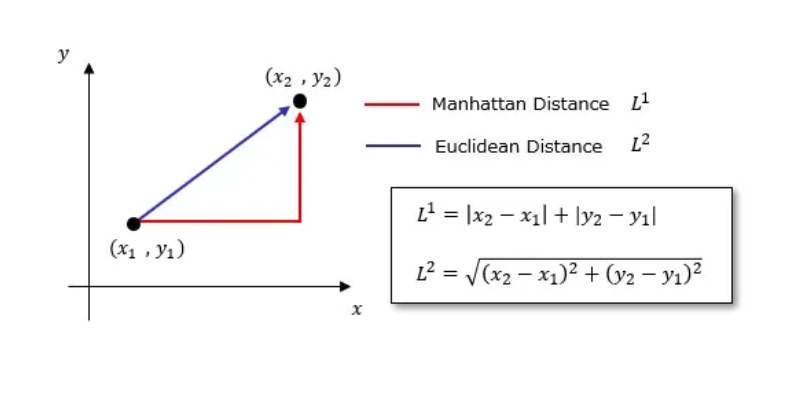

In [7]:
from typing import Callable

class KNN:
    x: np.ndarray
    y: np.ndarray
    C: np.ndarray | int
    K: int
    dist_fn: Callable
    
    def __init__(self, K = 1, dist_fn: Callable = manhattan):
        self.dist_fn = dist_fn
        self.K = K

    def fit(self, x: np.ndarray, y: np.ndarray):
        '''
        Store the training data using this method, as it is a lazy learner.
        '''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        '''
        Makes a prediction using the stored training data and the test data given as argument.
        '''
        num_test = x_test.shape[0]
        # Calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None, :, :], x_test[:, None, :])
        # ith-row of KNNs stores the indices of k closest training samples to the ith-test sample
        knns = np.zeros((num_test, self.K), dtype=int)
        # ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # Counts the number of instances of each class in the K-closest training samples
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        # Simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

We next `fit` the model (for KNN no learning occurs in training time), and make a prediction on test set (all the computation takes place during testing). We further connect each test node to its closest nearest neighbors in the plot. Here we're using the Manhattan metric as the default.

knns shape: (50, 3)
y_prob shape: (50, 3)
accuracy is 74.0%


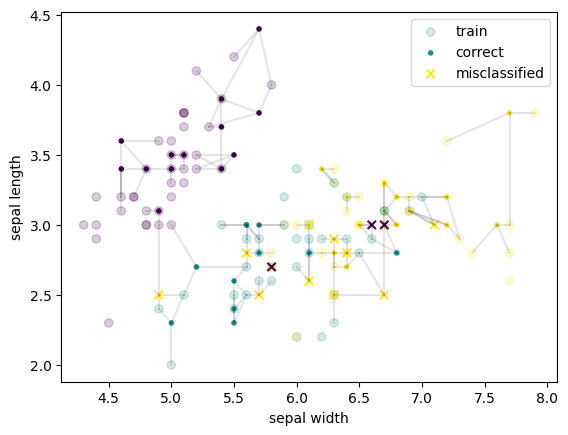

In [8]:
model = KNN(K=3)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

# To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}%')

# Boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

# Visualization of the points
plt.scatter(x_train[:, 0],         x_train[:, 1],         c=y_train, alpha=0.2,  marker='o',  label='train')
plt.scatter(x_test[correct, 0],    x_test[correct, 1],    c=y_pred[correct],     marker='.',  label='correct')
plt.scatter(x_test[incorrect, 0],  x_test[incorrect, 1],  c=y_test[incorrect],   marker='x',  label='misclassified')

# Connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.show()

## Decision Boundaries
To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

Using K=1


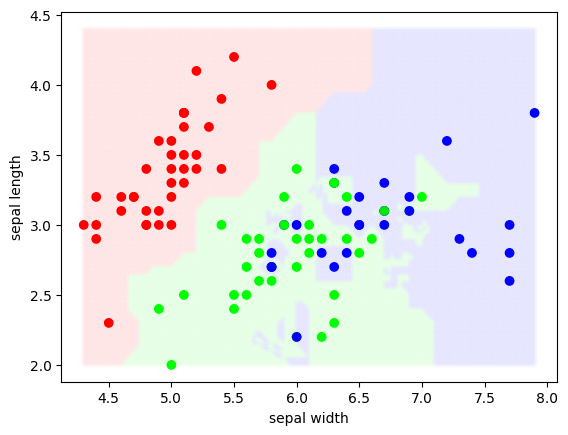

Using K=2


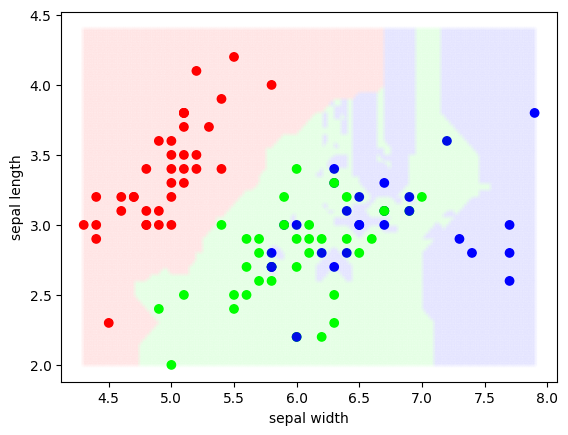

Using K=3


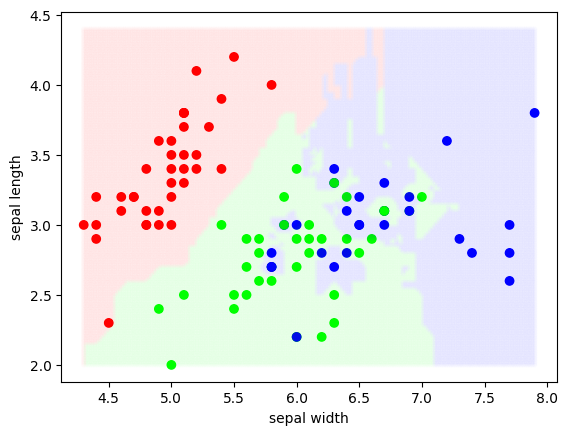

In [9]:
# We can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)

# To features values as a mesh
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack( (x0.ravel(), x1.ravel()) ).T

for k in range(1, 4):
    model = KNN(K=k)
    print(f'Using K={k}')

    y_train_prob = np.zeros((y_train.shape[0], qty_class_labels))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

    #to get class probability of all the points in the 2D grid
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

    plt.scatter(x_train[:, 0],  x_train[:, 1],  c=y_train_prob,  alpha=1,     marker='o',)
    plt.scatter(x_all[:, 0],    x_all[:, 1],    c=y_pred_all,    alpha=0.01,  marker='.')
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.show()

**[Practice]**

Great! Now can you do that all over again using your euclidean distance metric you defined yourself? Where do you need to change the code to use that metric?

knns shape: (50, 3)
y_prob shape: (50, 3)
accuracy is 74.0%


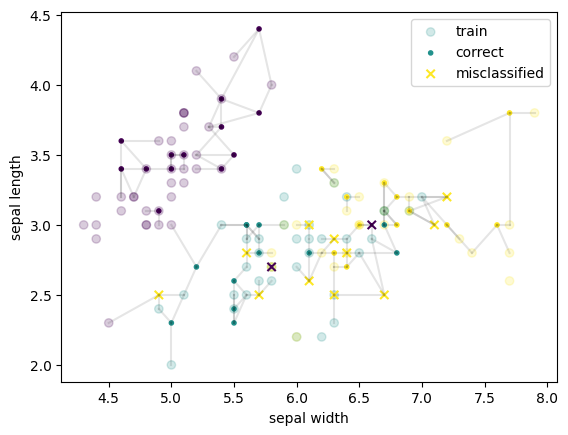

In [10]:
model = KNN(K=3, dist_fn=euclidean)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

# To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}%')

# Boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

# Visualization of the points
plt.scatter(x_train[:, 0],         x_train[:, 1],         c=y_train, alpha=0.2,  marker='o',  label='train')
plt.scatter(x_test[correct, 0],    x_test[correct, 1],    c=y_pred[correct],     marker='.',  label='correct')
plt.scatter(x_test[incorrect, 0],  x_test[incorrect, 1],  c=y_test[incorrect],   marker='x',  label='misclassified')

# Connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.show()

Using K=1


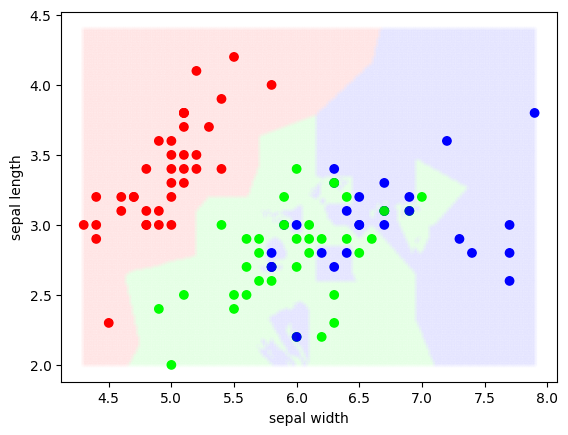

Using K=2


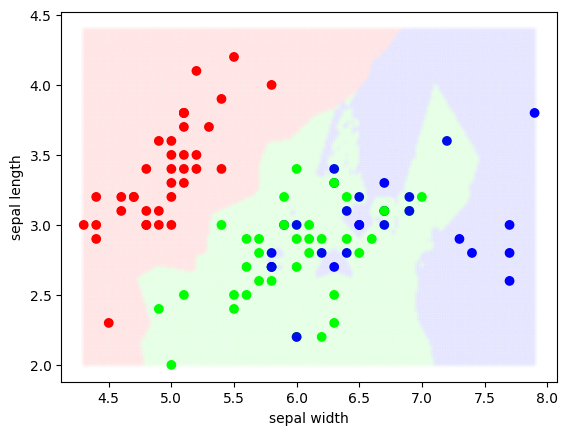

Using K=3


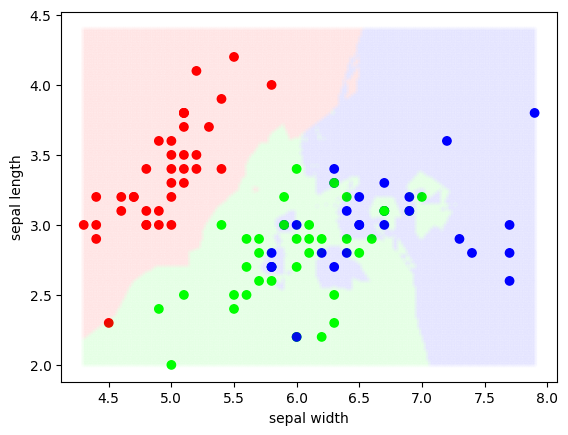

In [11]:
# We can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)

# To features values as a mesh
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack( (x0.ravel(), x1.ravel()) ).T

for k in range(1, 4):
    model = KNN(K=k, dist_fn=euclidean)
    print(f'Using K={k}')

    y_train_prob = np.zeros((y_train.shape[0], qty_class_labels))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

    #to get class probability of all the points in the 2D grid
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

    plt.scatter(x_train[:, 0],  x_train[:, 1],  c=y_train_prob,  alpha=1,     marker='o',)
    plt.scatter(x_all[:, 0],    x_all[:, 1],    c=y_pred_all,    alpha=0.01,  marker='.')
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.show()

**[Practice]**

Ok now that we've implemented our own function, let's try it with the sklearn function! Don't forget to use a test size of .3333 (to mirror the same train/test split above). Also, it's fine to use the default distance metric in `KNeighborsClassifier`.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Split the data into training and testing data (test_size=.3333)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1/3), shuffle=True)

## Instantiate learning model (k = 3)
model = KNeighborsClassifier(n_neighbors=3)

## Fit the model
model.fit(x_train, y_train)

## Predict the Test set results
y_pred = model.predict(x_test)

## Print the accuracy score (should be above 70%!!!)
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%')

Accuracy: 74.0%


**Easier huh?!**

Yeah, quite a bit easier. 

However, it would have been even easier than that if we had more instructions on how to utilize SKLearn and NumPy, as well as expected input and return types, as they're not exactly known for their self-documenting and easy-to-learn nature. 

Take the `euclidean` lambda for example. I had no idea what its signature should be. My first implementation failed, so I had to resort to making GitHub Copilot write it for me with the explicit instruction to match the input and return signature of the `manhattan` lambda.

Also, I had no idea what the train-test split should be. In the original given manual implementation, we used the first 100 and last 100 points of the dataset, but this leads to an overlap of 33%. I wasn't aware of this until I dug into the Iris dataset and noticed that it only has 150 points, so I had to rewrite the implementations that used `train_test_split` to use $\frac13$ instead of $\frac12$, as I had assumed the dataset had 200 points. However, this $\frac13$ split doesn't align with the original given manual implementation, they are using a split of $\frac23$, not $\frac13$.